In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mars-rover-environmental-monitoring-station/REMS_Mars_Dataset.csv


In [2]:
# Import other modules
import matplotlib.pyplot as plt

In [3]:
# Import the scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn import linear_model

### 0. Check the data

In [4]:
# Add data to dataframe
df = pd.read_csv("/kaggle/input/mars-rover-environmental-monitoring-station/REMS_Mars_Dataset.csv")

In [5]:
df["shaved_earth_date_time"] = pd.to_datetime(df["earth_date_time"].str.replace('Earth, ','').str.replace(' UTC',''),format='%Y-%m-%d')
sorted_df = df.sort_values(by='shaved_earth_date_time')
sample_df = df[sorted_df['earth_date_time'].str.contains('2021')]
df = df.rename(columns={"humidity(%)":"humidity(Pr)"})
df.head()

/tmp/ipykernel_1206/1758284699.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_df = df[sorted_df['earth_date_time'].str.contains('2021')]


,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),wind_speed(m/h),humidity(Pr),sunrise,sunset,UV_Radiation,weather,shaved_earth_date_time
0,"Earth, 2022-01-26 UTC","Mars, Month 6 - LS 163°",Sol 3368,-3,-71,10,-84,707,Value not available,Value not available,05:25,17:20,moderate,Sunny,2022-01-26
1,"Earth, 2022-01-25 UTC","Mars, Month 6 - LS 163°",Sol 3367,-3,-72,10,-87,707,Value not available,Value not available,05:25,17:20,moderate,Sunny,2022-01-25
2,"Earth, 2022-01-24 UTC","Mars, Month 6 - LS 162°",Sol 3366,-4,-70,8,-81,708,Value not available,Value not available,05:25,17:21,moderate,Sunny,2022-01-24
3,"Earth, 2022-01-23 UTC","Mars, Month 6 - LS 162°",Sol 3365,-6,-70,9,-91,707,Value not available,Value not available,05:26,17:21,moderate,Sunny,2022-01-23
4,"Earth, 2022-01-22 UTC","Mars, Month 6 - LS 161°",Sol 3364,-7,-71,8,-92,708,Value not available,Value not available,05:26,17:21,moderate,Sunny,2022-01-22


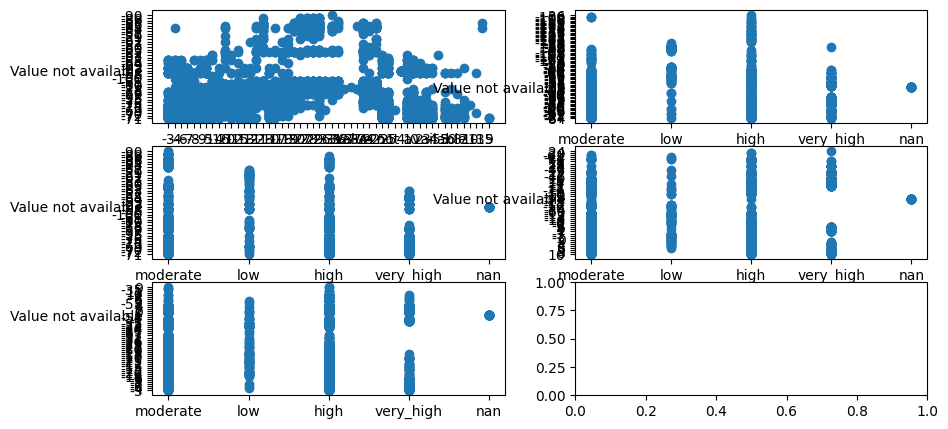

In [6]:
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(10,5))

# Plot 0,0
axes[0][0].scatter(df["max_ground_temp(°C)"],df["min_ground_temp(°C)"])
# Plot 0,1
axes[0][1].scatter(df["UV_Radiation"].astype("str"),df["min_air_temp(°C)"])
# Plot 1,0
axes[1][0].scatter(df["UV_Radiation"].astype("str"),df["min_ground_temp(°C)"])
# Plot 1,1
axes[1][1].scatter(df["UV_Radiation"].astype("str"),df["max_air_temp(°C)"])
# Plot 2,0
axes[2][0].scatter(df["UV_Radiation"].astype("str"),df["max_ground_temp(°C)"])

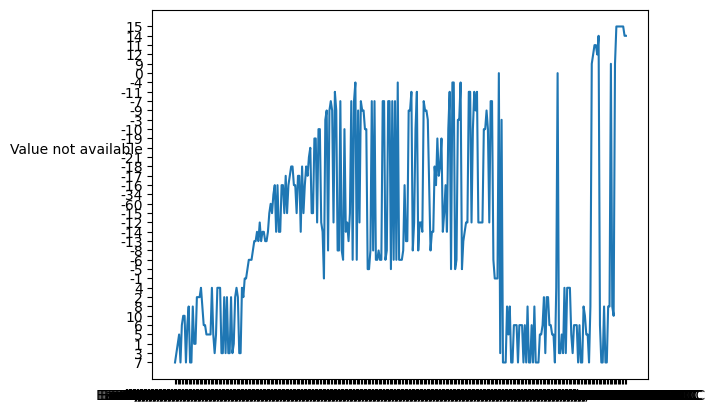

In [7]:
fig,axes = plt.subplots()
axes.plot(sample_df['earth_date_time'],sample_df['max_air_temp(°C)'])

### 1. Cleaning the data

In [8]:
# Convert the Earth date time values to year,month,day columns
df["shaved_earth_date_time"] = pd.to_datetime(df["earth_date_time"].str.replace('Earth, ','').str.replace(' UTC',''),format='%Y-%m-%d')
df["earth_year"] = df["shaved_earth_date_time"].dt.year
df["earth_month"] = df["shaved_earth_date_time"].dt.month
df["earth_day"] = df["shaved_earth_date_time"].dt.day

# Drop the shaved_earth_date_time column
df=df.drop("shaved_earth_date_time",axis=1)

In [9]:
# There are two columns, wind speed and humidity, that have no clolumns of value and should be dropped
df=df.drop("wind_speed(m/h)",axis=1)
df=df.drop("humidity(Pr)",axis=1)

In [10]:
# Convert all empty values to pd.NaN values for later filtering
df = df.replace('Value not available',pd.NA)

# Then, drop all NaN values
df = df.dropna()

In [11]:
# Convert the sunrise and sunset values into hour and minute numbers
df[['sunrise_hours','sunrise_minutes']] = df['sunrise'].str.split(':',expand=True)
df[['sunset_hours','sunset_minutes']] = df['sunset'].str.split(':',expand=True)

In [12]:
# Convert the recently created columns to type int for later machine learning
df['sunrise_hours']=df['sunrise_hours'].astype('int')
df['sunrise_minutes']=df['sunrise_minutes'].astype('int')
df['sunset_hours']=df['sunset_hours'].astype('int')
df['sunset_minutes']=df['sunset_minutes'].astype('int')

In [13]:
# Convert the pressure values to int type as well as the other columns that will be used to train the model in
df['mean_pressure(Pa)']=df['mean_pressure(Pa)'].astype('int')
df['max_ground_temp(°C)']=df['max_ground_temp(°C)'].astype('int')
df['min_ground_temp(°C)']=df['min_ground_temp(°C)'].astype('int')
df['max_air_temp(°C)']=df['max_air_temp(°C)'].astype('int')
df['min_air_temp(°C)']=df['min_air_temp(°C)'].astype('int')

In [14]:
# Make a new dataframe that only contains the columns that will be used to train the model
columns_to_keep=[
    'mean_pressure(Pa)',
    'earth_year',
    'earth_month',
    'earth_day',
    'max_ground_temp(°C)',
    'min_ground_temp(°C)',
    'max_air_temp(°C)',
    'max_air_temp(°C)'
]
compact_df = df[columns_to_keep]

### 2. Train the model

In [15]:
# Separate the data from the predicting column
X = compact_df.drop('mean_pressure(Pa)',axis=1)
y = compact_df['mean_pressure(Pa)']

In [16]:
# Make training and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [17]:
# Create the model fit and fit the model to the data
cls = linear_model.Lasso()
model = cls.fit(X_train,y_train)

### 3. Score the model

In [18]:
model.score(X_test,y_test)

0.14604675176632498